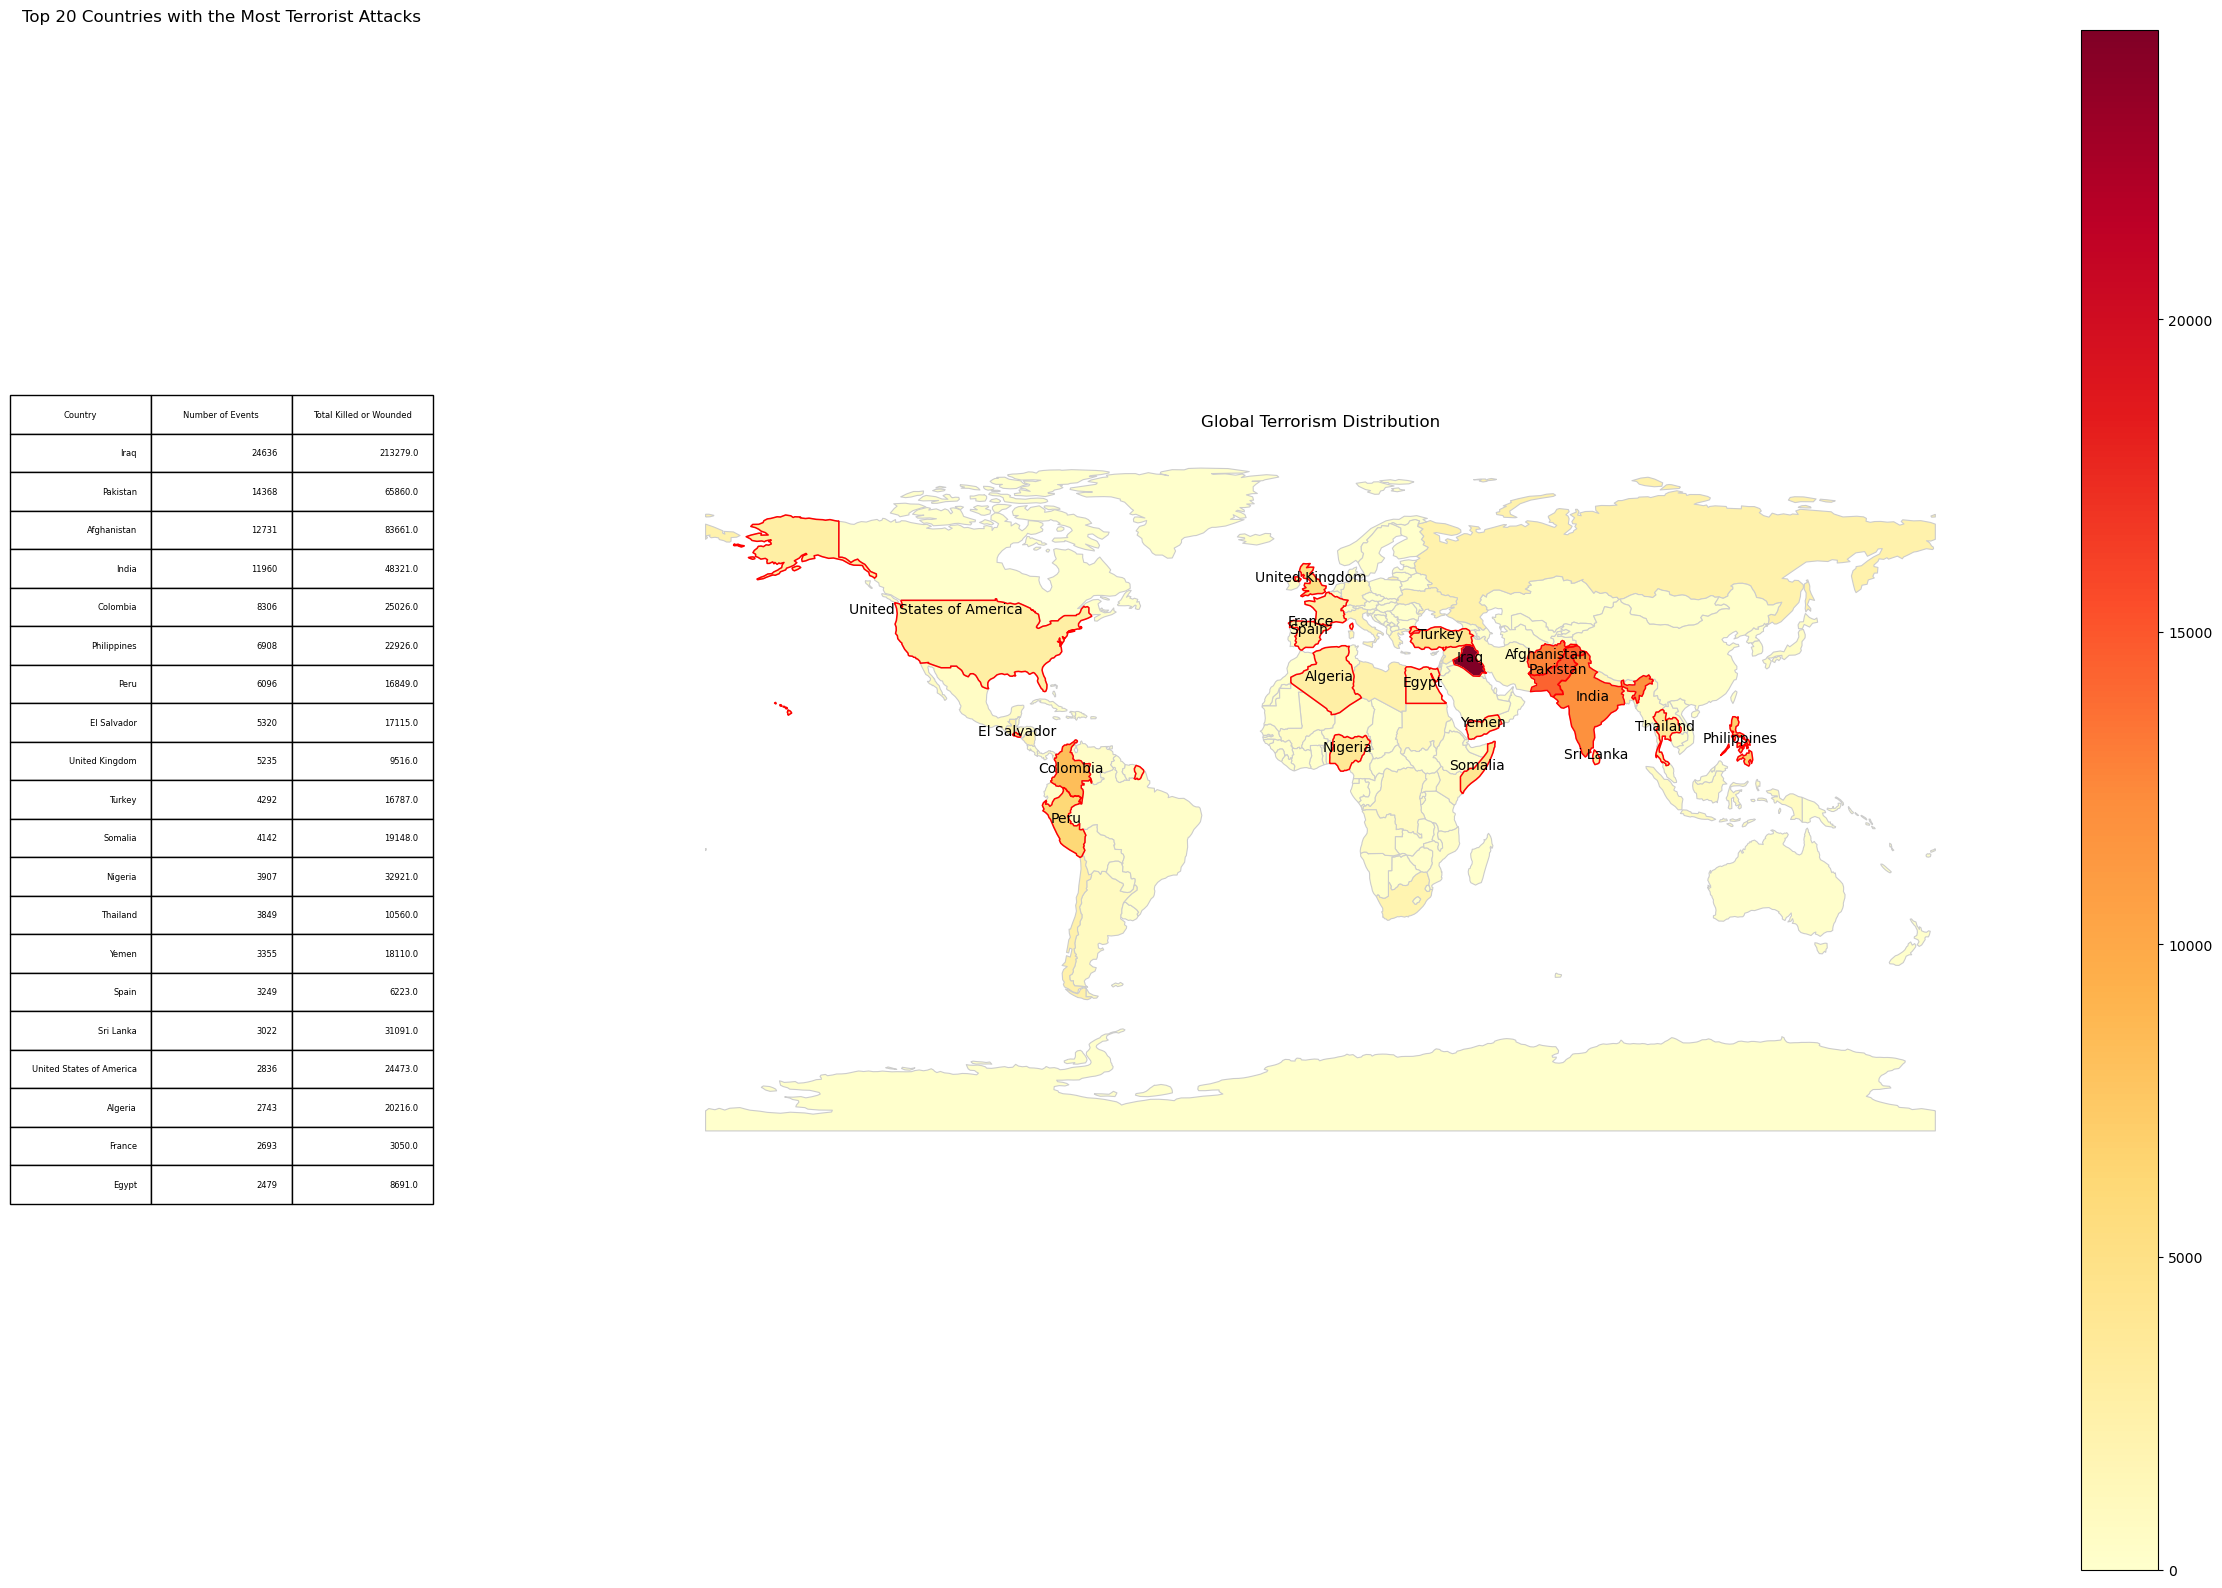

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('PerpsAdded.csv', encoding='ISO-8859-1', low_memory=False, sep=';')

def map_country_names(df):
    country_mappings = {
        'East Germany (GDR)': 'Germany',
        'West Germany (FRG)': 'Germany',
        'South Vietnam': 'Vietnam',
        'Rhodesia': 'Zimbabwe',
        'Soviet Union': 'Russia',
        'North Yemen': 'Yemen',
        'South Yemen': 'Yemen',
        "People's Republic of the Congo": 'Dem. Rep. Congo',
        'Republic of the Congo': 'Dem. Rep. Congo',
        'Zaire': 'Dem. Rep. Congo',
        'Democratic Republic of the Congo': 'Dem. Rep. Congo',
        'Czechoslovakia': 'Czech Republic',
        'Serbia-Montenegro': 'Serbia',
        'United States': 'United States of America'
    }
    df['country_txt'] = df['country_txt'].replace(country_mappings)
    return df

df = map_country_names(df)


# Aggregate the number of terror events per country
country_terror_counts = df['country_txt'].value_counts().reset_index()
country_terror_counts.columns = ['Country', 'Number of Events']

country_killed_wounded = df.groupby('country_txt')[['nkill', 'nwound']].sum().reset_index()
country_killed_wounded['Total Killed or Wounded'] = country_killed_wounded['nkill'] + country_killed_wounded['nwound']
country_killed_wounded.drop(['nkill', 'nwound'], axis=1, inplace=True)
country_killed_wounded.columns = ['Country', 'Total Killed or Wounded']

# Merge the terror event counts and killed/wounded counts per country
country_stats = pd.merge(country_terror_counts, country_killed_wounded, on='Country')

# Load the world map dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the terror data with the world map dataset
world_terror = world.merge(country_terror_counts, left_on='name', right_on='Country', how='left')

# Fill missing values with 0
world_terror['Number of Events'].fillna(0, inplace=True)

top_20 = country_terror_counts.head(20)
top_20_map = world_terror[world_terror['Country'].isin(top_20['Country'])]

# Normalize the data for visualization
world_terror['count_normalized'] = world_terror['Number of Events'] / world_terror['Number of Events'].max()

# Define the colormap
cmap = plt.get_cmap('YlOrRd')

# Create a subplot with a table and a map
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(30, 20))

# Plot the world map with terror events
world_terror.plot(column='count_normalized', cmap=cmap, linewidth=0.8, edgecolor='0.8', ax=ax2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=world_terror['Number of Events'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax2)

# Set the title
ax2.set_title('Global Terrorism Distribution')

# Remove axes
ax2.set_axis_off()

# Find the midpoint of the yellow color range in the colormap
yellow_midpoint = (cmap(0.5)[0] + cmap(0.5)[1] + cmap(0.5)[2]) / 3

# Add the names of the top 20 countries to the map
for idx, row in top_20_map.iterrows():
    plt.annotate(text=row['Country'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10, color='black')

# Plot the top 20 countries in a different color and larger size
top_20_map.plot(ax=ax2, color='none', edgecolor='red', linewidth=1.1, markersize=30)

top_20 = country_stats.head(20)
table = ax1.table(cellText=top_20.values, colLabels=top_20.columns, loc='center')

# Set the font size of the cells in the table
table_cells = table.get_celld()
for i in range(1, len(top_20) + 1):
    for j in range(len(top_20.columns)):
        cell = table_cells[(i, j)]
        cell.set_text_props(fontsize=40)
        cell.set_height(0.025)

# Set the header cell height to match the other cells
for j in range(len(top_20.columns)):
    header_cell = table_cells[(0, j)]
    header_cell.set_height(0.025)
    header_cell.set_text_props(fontsize=40)

# Set the title of the table
ax1.set_title('Top 20 Countries with the Most Terrorist Attacks')

# Remove axes
ax1.axis('off')

# Save the figure
plt.savefig('global_terrorism_map_with_country_names_and_table.png', dpi=300)

plt.show()